# Plots for the output files of paleoda/notebooks_da/experiment_global_07_11.ipynb

Type of plots | Inputs
    - gmt of different methods| anomaly period, variable (tsurf, prec, d18O) | title
        - all methods in one plot
    - gmt comparison: prior, mean climatology, reconstruction 
    - regional plot (erb figure 10 comparison)
        - select bounds, variable, centuries, anomaly period
        - one shared colorbar below
        - nice to have: overlay slp if available, + mean of proxy anomaly
    - regional plot: compare to prior simulation
    - hovmöller (latitudinal mean) plot:
        - | variable, anomaly period
    - nh/sh plot (take code from above and define region)

Additional plots:
    with the code from above:
    - PHYDA reconstructions (can be used above?) https://zenodo.org/record/1198817 (only has evaporation - transpiration)
    - LMR2 https://www.atmos.uw.edu/~hakim/lmr/LMRv2/index.html ()





In [2]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

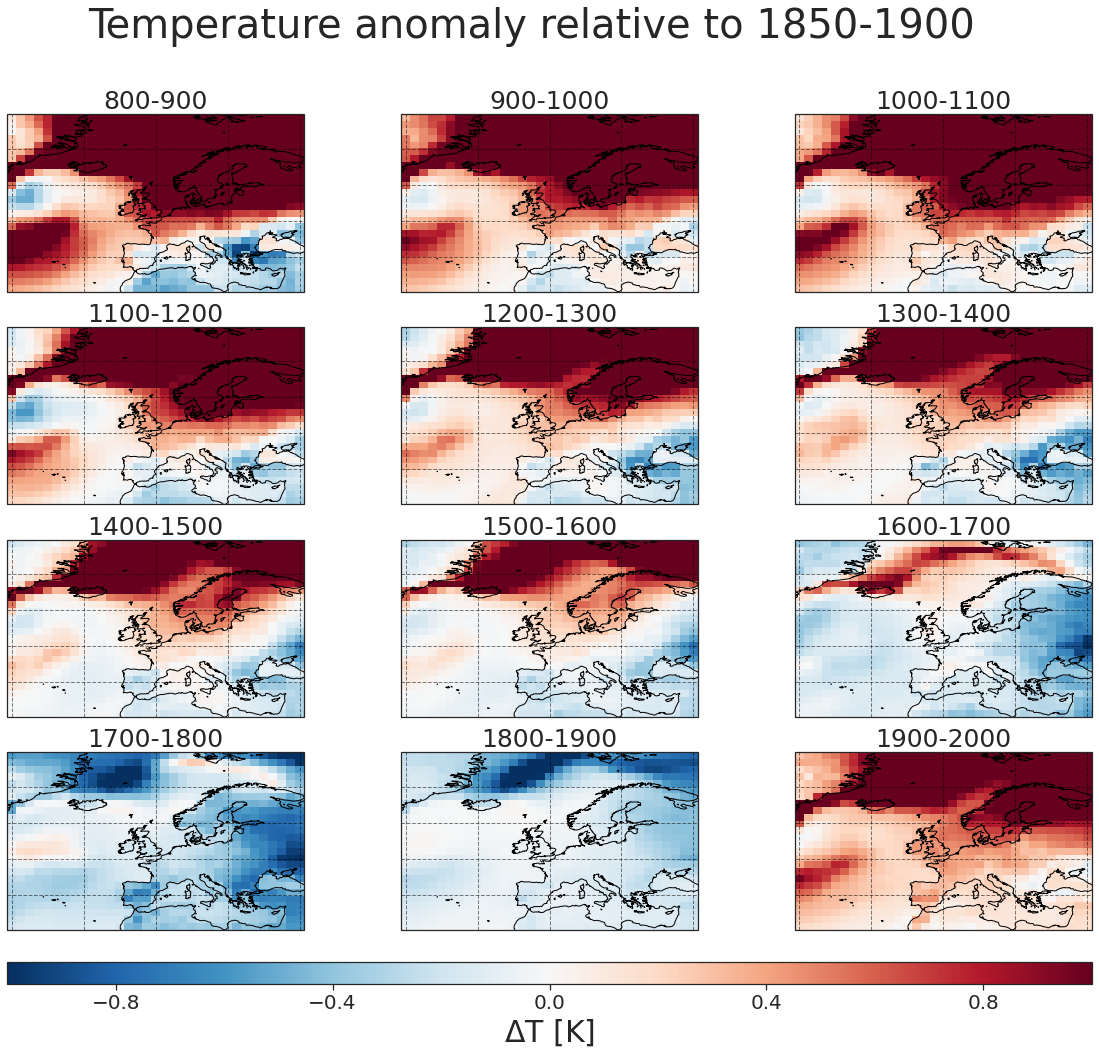

In [183]:
data_0=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/800_1999_nofrac_reuse/iCESM_ano.nc')['tsurf_mean']

start='1850'
end='1900'
freq=100

data=data_0-data_0.sel(time=slice(start,end)).mean('time')

bounds=[[30,80],[320,40]]

data=data.resample(time=(str(freq)+'YS'),label='left').mean('time')

#cut fields
lat=data.lat
lon=data.lon
lats,lons=bounds[0],bounds[1]
if lons[0]<lons[1]:    #selection of longitudes
    sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
    sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
else:    #cross zero-meridian region option
    sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
    sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
    sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
    sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
data_cut=data.sel(lat=sel_lat,lon=sel_lon)


data_cut['lon']=xr.where(data_cut['lon'] < 180, data_cut['lon'], data_cut['lon']-360)
data_cut=data_cut.sortby('lon')

sns.set_theme(style="white")

title='Temperature anomaly relative to '+start+'-'+end

vmax=1
vmin=-1

figsize=(20,15)
fig, axes = plt.subplots(ncols=3,nrows=4,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle(title,fontsize=40)

cmap='RdBu_r' #BrBG_r for precipitation

label=r'$\Delta$T [K]'

for i,t in enumerate(data_cut.time):
    ax=axes.flatten()[i]
    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    plot=data_cut.sel(time=t).plot(vmax=vmax,vmin=vmin,ax=ax,cmap=cmap,add_colorbar=False)
    
    ax.set_ylabel('',fontsize=30,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)
    
    
    year=data_cut.time.dt.year[i].values
    string=str(year)+'-'+str(year+freq)
    ax.set_title(string,fontsize=25)
        
p0=axes.flatten()[-3].get_position().get_points().flatten()
p2=axes.flatten()[-1].get_position().get_points().flatten()

from matplotlib import ticker
    
#colormap for left plot
ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p2[2]-p0[0]), 0.02])
cb=fig.colorbar(plot, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(label,fontsize=30)


In [70]:
def regional_plot(folder,model,ano=True,bounds=[[30,80],[310,60]], var='tsurf',title='Temperature',anomaly_period=['1850','1900'],proxies_ano=False, freq=100,start_y='0800',end_y='1999',vmax=10,vmin=-10,
                     cmap='RdBu_r', #BrBG_r for precipitation
                    size=100,
                    label=r'$\Delta$T [K]'):
    #load_dataset
    if ano==True:
        p=folder+model+'_ano.nc'
    else:
        p=folder+model+'_abs.nc'
    
    data_org=xr.open_dataset(p)
    
    start=anomaly_period[0]
    end=anomaly_period[1]
    
    #eventually extract proxies
    if proxies_ano==True:
        proxies=data_org['proxies']
        #compute anomaly period
        proxies=proxies-proxies.sel(time=slice(start,end)).mean('time')
        proxies=proxies.resample(time=(str(freq)+'YS'),label='left').mean('time')
        
        proxies_lat=data_org['proxies_lat']
        proxies_lon=data_org['proxies_lon']
        proxies['lat']=proxies_lat
        proxies['lon']=proxies_lon
    
    data_0=data_org[var+'_mean']
    data_0=data_0.sel(time=slice(start_y,end_y))

    data=data_0-data_0.sel(time=slice(start,end)).mean('time')
    data=data.resample(time=(str(freq)+'YS'),label='left').mean('time')

    #cut fields
    lat=data.lat
    lon=data.lon
    lats,lons=bounds[0],bounds[1]
    if lons[0]<lons[1]:    #selection of longitudes
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    else:    #cross zero-meridian region option
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    data_cut=data.sel(lat=sel_lat,lon=sel_lon)
    
    #also cut proxy estimates in region
    if proxies_ano==True:
        lat=proxies.lat
        lon=proxies.lon
        lats,lons=bounds[0],bounds[1]
        if lons[0]<lons[1]:    #selection of longitudes
            proxies=proxies.where( (proxies.lat >= lats[0] ) & (proxies.lat <= lats[1]), drop=True)
            proxies=proxies.where( (proxies.lon >= lons[0] ) & (proxies.lon <= lons[1]), drop=True)
        else:    #cross zero-meridian region option
            proxies = proxies.where( (proxies.lat >= lats[0] ) & (proxies.lat <= lats[1]), drop=True)
            lon=proxies.lon
            sel_lon_1 = lon.where((lon >= lons[0] ), drop=True)
            sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
            sel_lon=np.concatenate([sel_lon_1,sel_lon_2])
            
            #workaround!
            prox1=proxies.where((lon <= lons[1] ),drop=True)
            prox2=proxies.where((lon >= lons[0] ),drop=True)
            proxies=xr.merge([prox1,prox2])['proxies']
            
            #proxies=proxies.where(proxies.lon==sel_lon,drop=True)
        
        proxies['lon']=xr.where(proxies['lon'] < 180, proxies['lon'], proxies['lon']-360)
        proxies=proxies.sortby('lon')
    

    
    data_cut['lon']=xr.where(data_cut['lon'] < 180, data_cut['lon'], data_cut['lon']-360)
    data_cut=data_cut.sortby('lon')

    sns.set_theme(style="white")

    title=title+' anomaly relative to '+start+'-'+end+' ('+str(model)+')'

    figsize=(20,15)
    fig, axes = plt.subplots(ncols=3,nrows=4,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=40)

    for i,t in enumerate(data_cut.time):
        ax=axes.flatten()[i]
        ax.add_feature(cfeature.COASTLINE)
        ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

        plot=data_cut.sel(time=t).plot(vmax=vmax,vmin=vmin,ax=ax,cmap=cmap,add_colorbar=False)
        year=data_cut.time.dt.year[i].values     
        
        #plot proxy values as scatter points
        if proxies_ano==True:
            prox_i=proxies[i].dropna('site')
            scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
            string=str(year)+'-'+str(year+freq)+' ['+str(np.round(np.min(prox_i.values),1))+','+str(np.round(np.max(prox_i.values),1))+']'
        else:
            string=str(year)+'-'+str(year+freq)
            
        ax.set_ylabel('',fontsize=30,rotation=0)
        ax.set_xlabel('',fontsize=30,rotation=0)

   
        ax.set_title(string,fontsize=25)

    p0=axes.flatten()[-3].get_position().get_points().flatten()
    p2=axes.flatten()[-1].get_position().get_points().flatten()

    from matplotlib import ticker

    #colormap variable
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p2[2]-p0[0]), 0.02])
    cb=fig.colorbar(plot, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label(label,fontsize=30)
    
    if proxies_ano==True:
        #colormap for d18O
        ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.15, (p2[2]-p0[0]), 0.02])
        cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal',cmap='PiYG')
        cb.ax.tick_params(labelsize=20)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.set_label(r'Proxy $\Delta(\delta^{18}$O)',fontsize=30)


In [13]:
bounds=bounds_europe

In [6]:
data_org=xr.open_dataset('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_reuse/iCESM_ano.nc')
start='1600'
end='1800'
freq=100

In [14]:
proxies=data_org['proxies']
#compute anomaly period
proxies=proxies-proxies.sel(time=slice(start,end)).mean('time')
proxies=proxies.resample(time=(str(freq)+'YS'),label='left').mean('time')

proxies_lat=data_org['proxies_lat']
proxies_lon=data_org['proxies_lon']
proxies['lat']=proxies_lat
proxies['lon']=proxies_lon

In [34]:
lat=proxies.lat
lon=proxies.lon
lats,lons=bounds[0],bounds[1]
if lons[0]<lons[1]:    #selection of longitudes
    proxies=proxies.where( (proxies.lat >= lats[0] ) & (proxies.lat <= lats[1]), drop=True)
    proxies=proxies.where( (proxies.lon >= lons[0] ) & (proxies.lon <= lons[1]), drop=True)
else:    #cross zero-meridian region option
    proxies = proxies.where( (proxies.lat >= lats[0] ) & (proxies.lat <= lats[1]), drop=True)
    lon=proxies.lon
    sel_lon_1 = lon.where((lon >= lons[0] ), drop=True).values
    sel_lon_2 = lon.where((lon <= lons[1]), drop=True).values
    sel_lon=np.concatenate([sel_lon_1,sel_lon_2])
    
    prox1=proxies.where((lon <= lons[1] ),drop=True)
    prox2=proxies.where((lon >= lons[0] ),drop=True)
    proxies=xr.merge([prox1,prox2])['proxies']

In [50]:
bounds_europe=[[30,85],[310,50]]
bounds_global=[[-90,90],[0,360]]

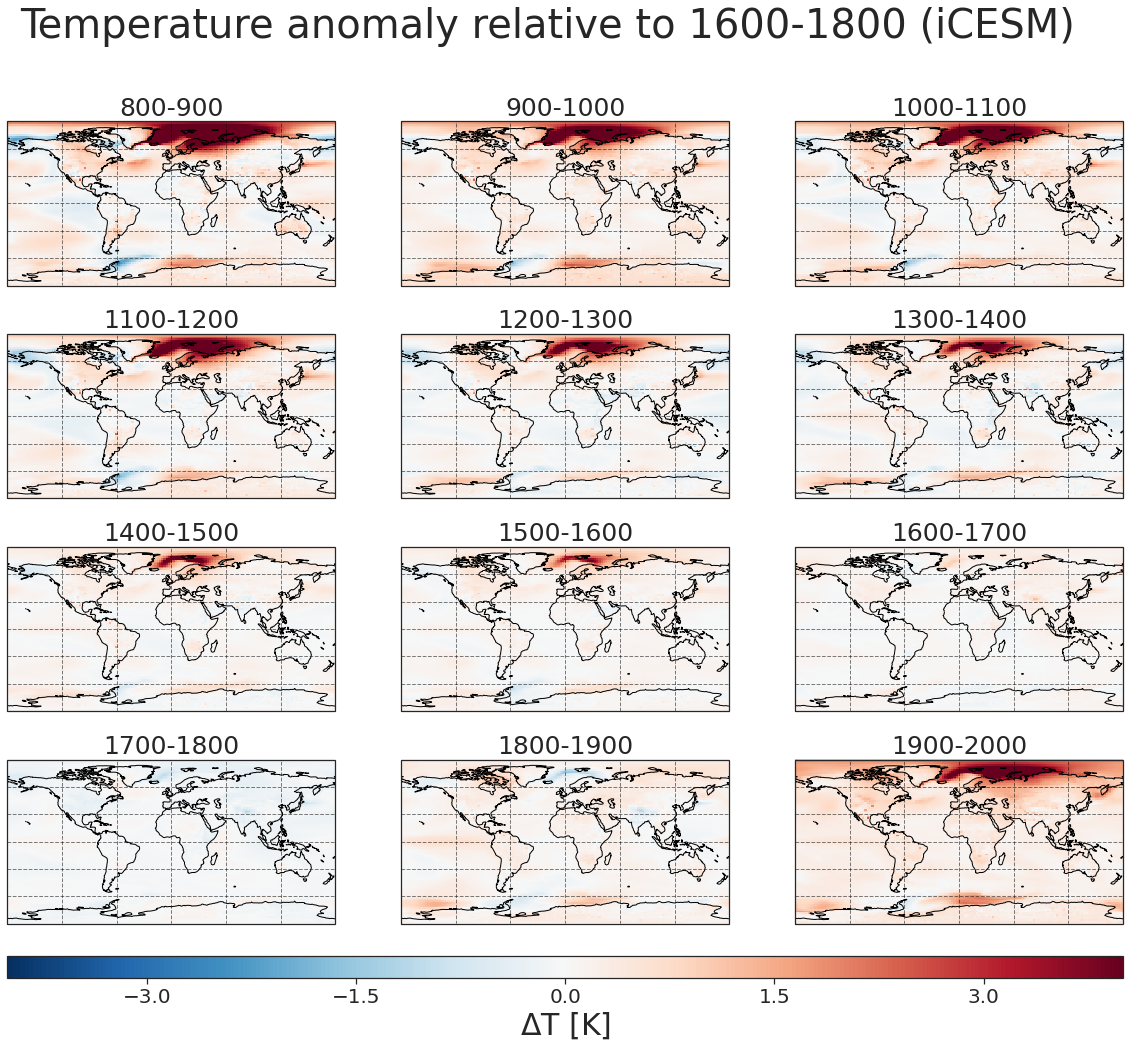

In [52]:
regional_plot('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=bounds_global, var='tsurf', 
              proxies_ano=False,
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=4,vmin=-4)

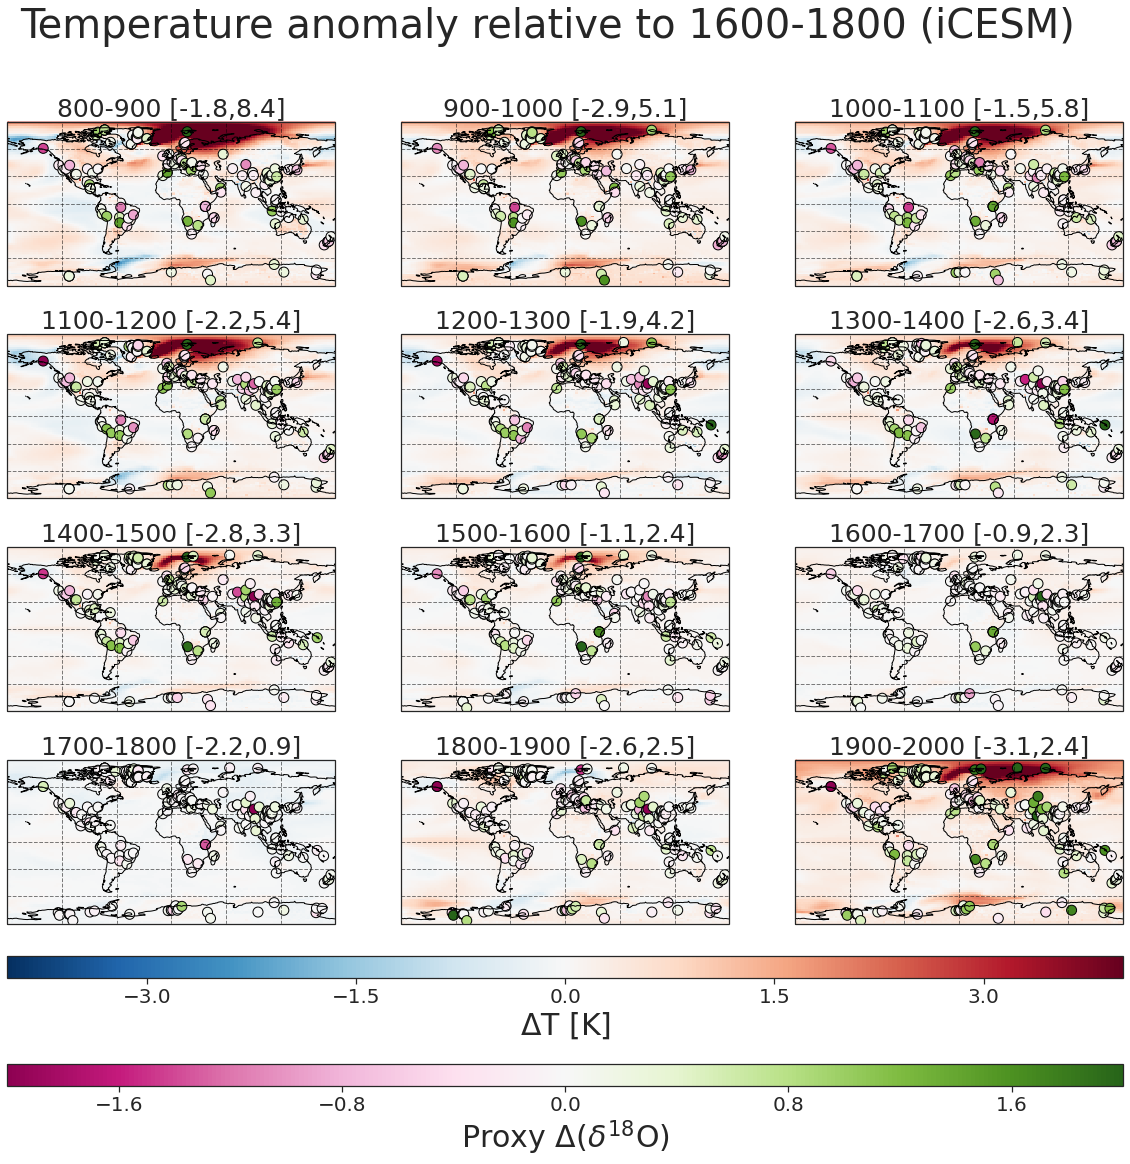

In [71]:
regional_plot('/home/mchoblet/paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=bounds_global, var='tsurf', 
              proxies_ano=True,
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=4,vmin=-4)

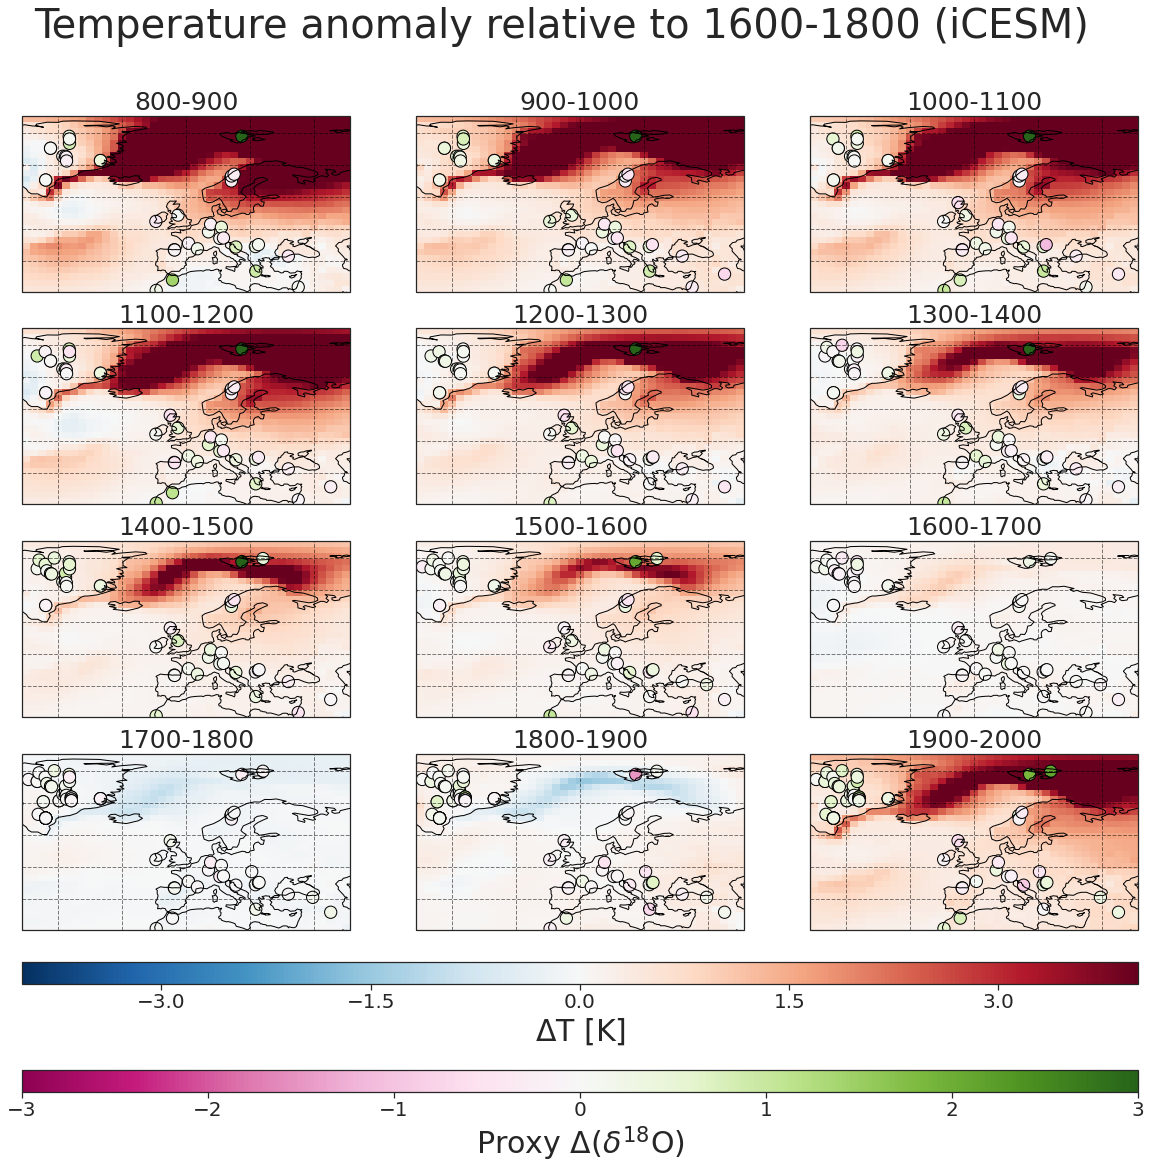

In [57]:
regional_plot('/home/mchoblet/paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=bounds_europe, var='tsurf', 
              proxies_ano=True, size=150,
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=4,vmin=-4)

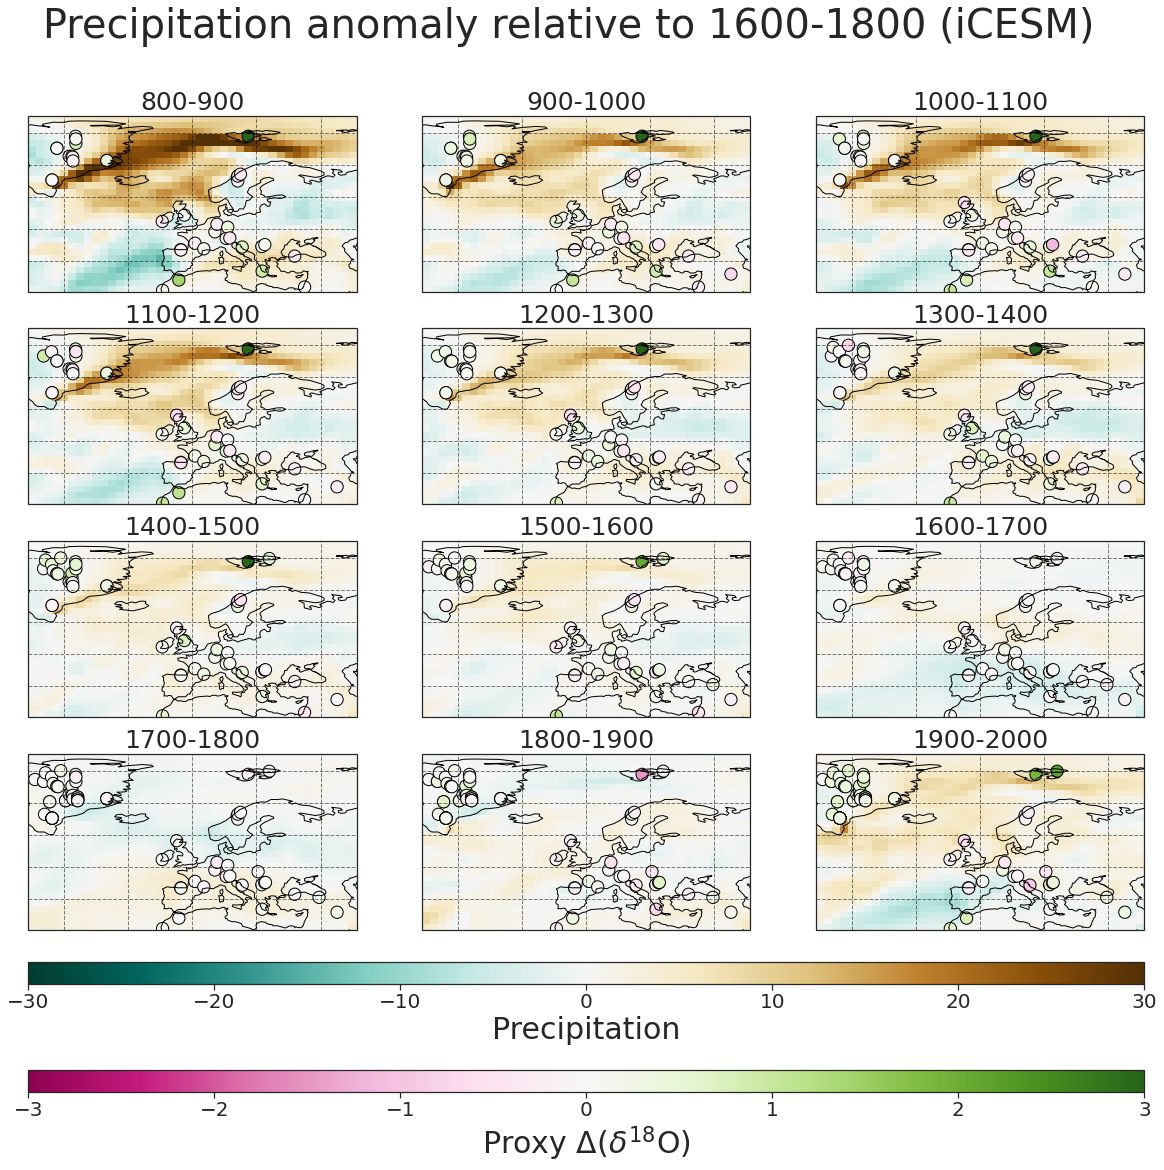

In [62]:
regional_plot('/home/mchoblet/paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=bounds_europe, var='prec', 
              proxies_ano=True, size=150,cmap='BrBG_r', label='Precipitation',
              title='Precipitation', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=30,vmin=-30)

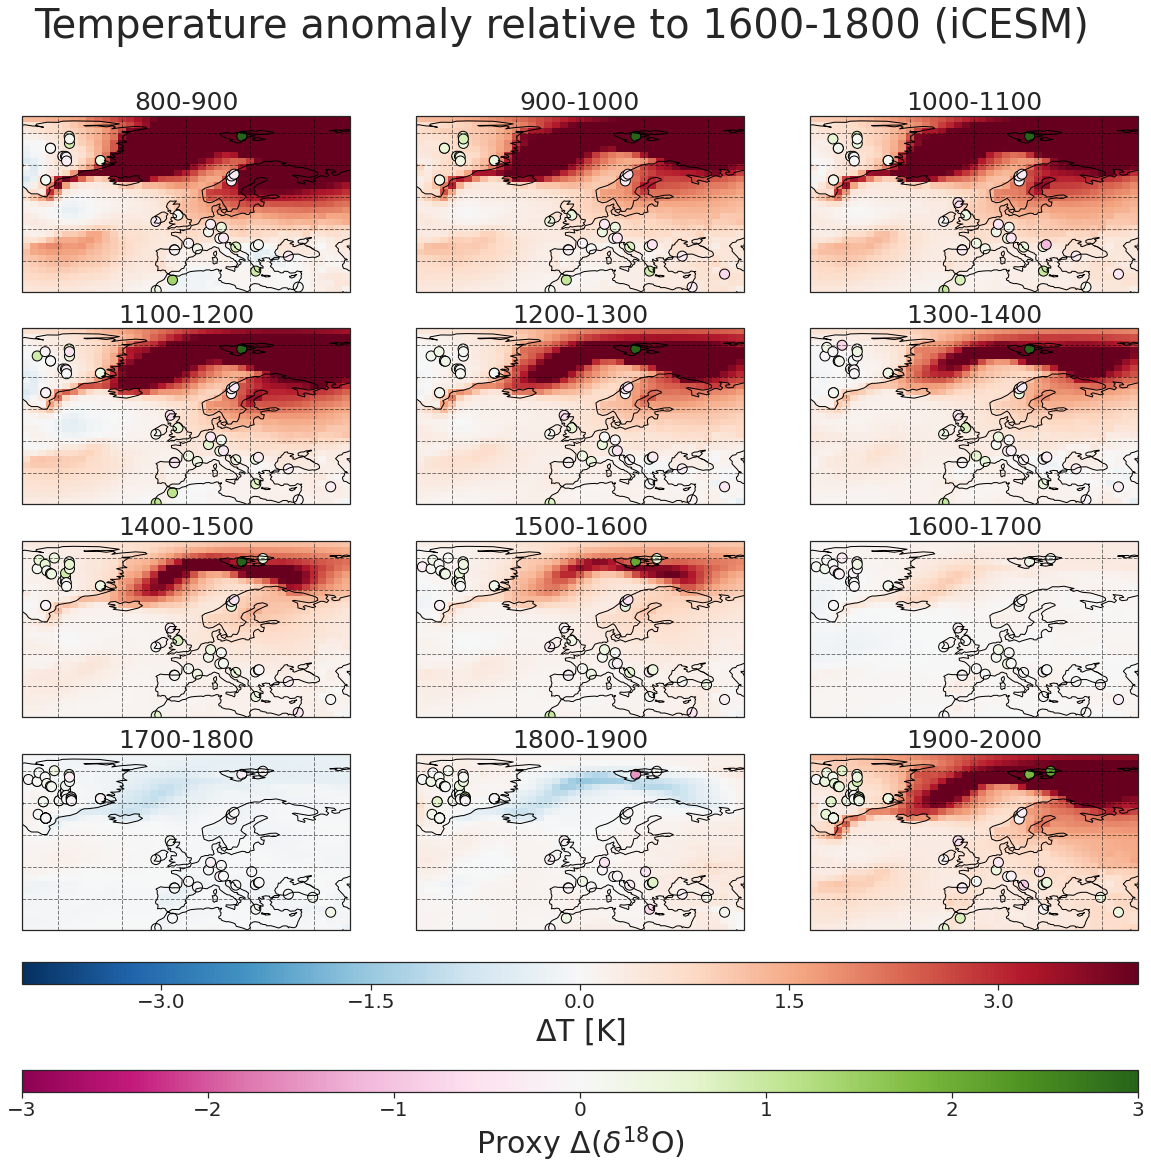

In [51]:
regional_plot('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=bounds_europe, var='tsurf', 
              proxies_ano=True,
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=4,vmin=-4)

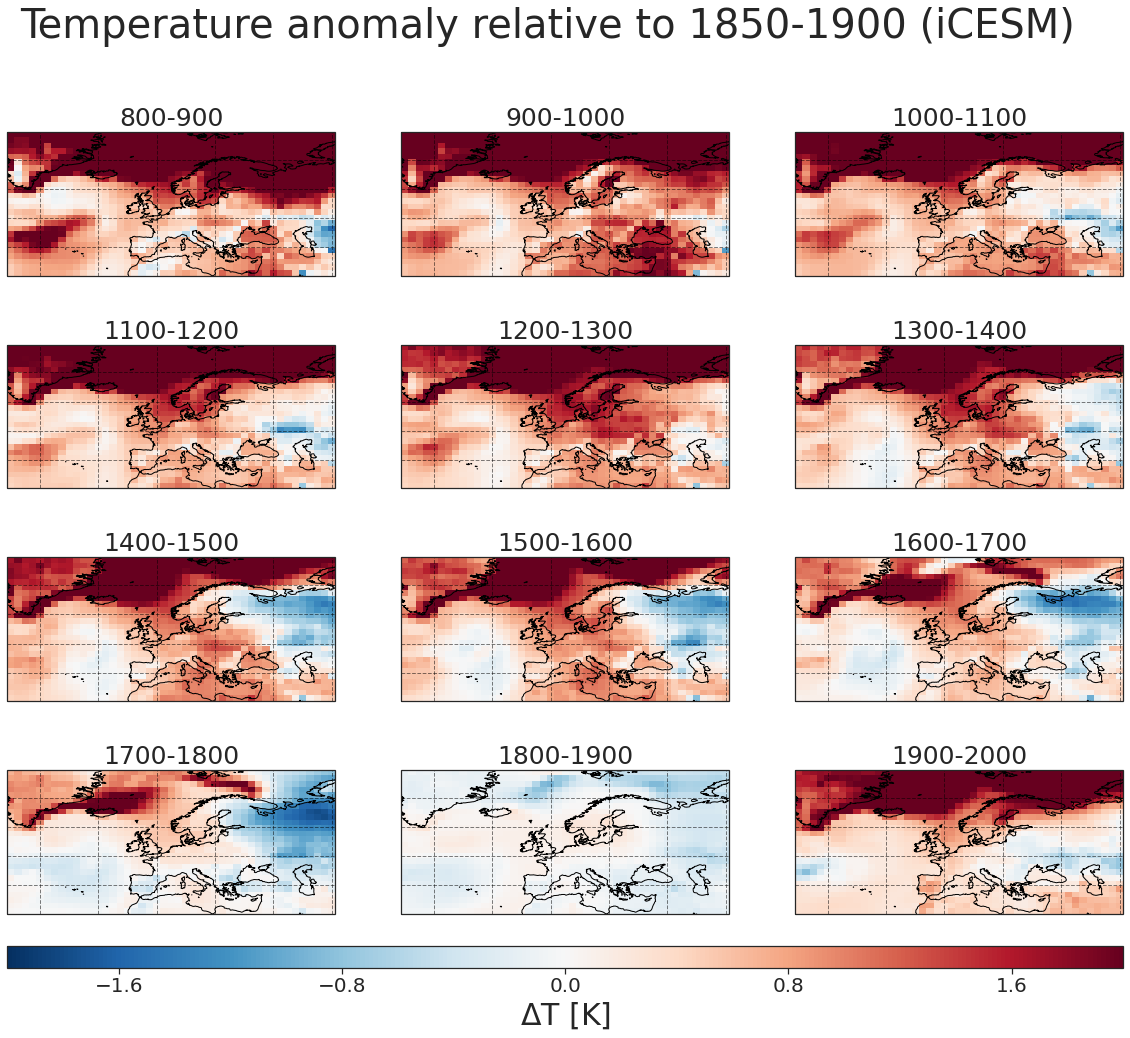

In [20]:
regional_plot('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=False,bounds=[[30,80],[310,60]], var='tsurf', 
              title='Temperature', anomaly_period=['1850','1900'],freq=100,start_y='0800',end_y='1999',vmax=2,vmin=-2)

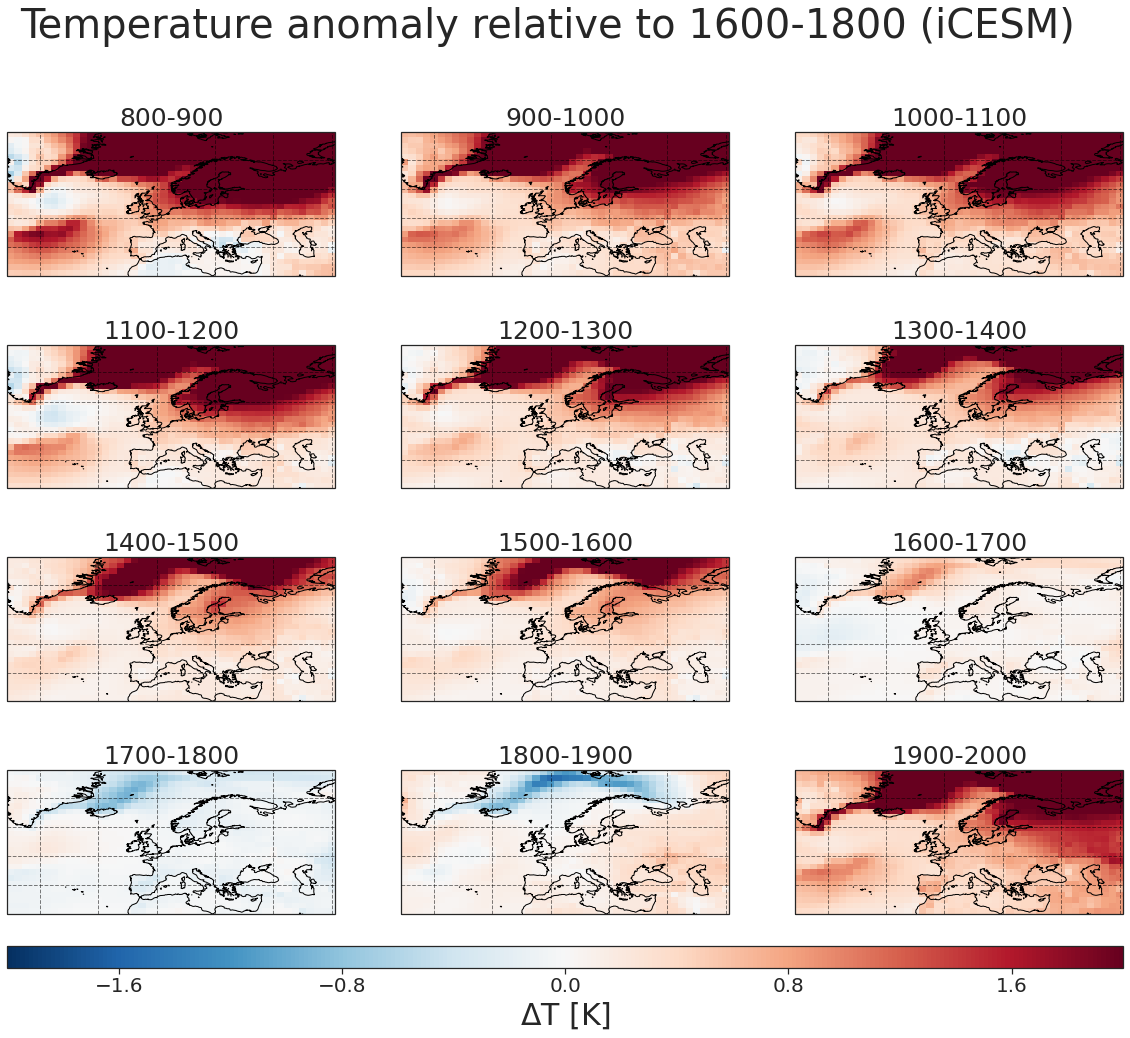

In [21]:
regional_plot('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_reuse/',model='iCESM',ano=True,bounds=[[30,80],[310,60]], var='tsurf', 
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=2,vmin=-2)

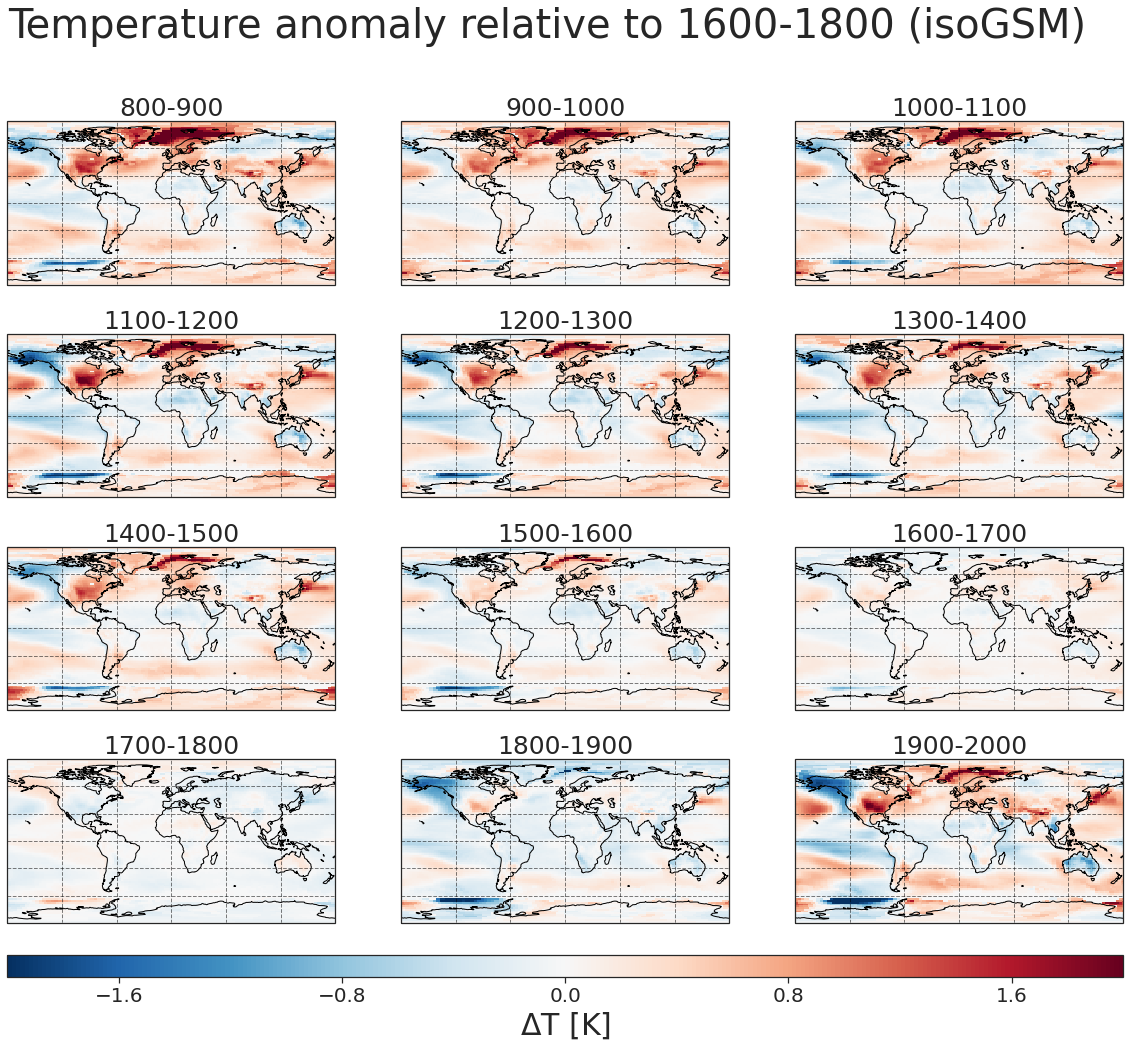

In [230]:
regional_plot('/home/mchoblet//paleoda/results/experiments/800_1999_nofrac_noreuse/',model='isoGSM',ano=True,bounds=bounds_global, var='tsurf',
              title='Temperature', anomaly_period=['1600','1800'],freq=100,start_y='0800',end_y='1999',vmax=2,vmin=-2)

In [220]:
phyda_path='/home/mchoblet/lmr_phyda_output/phyda.nc'


In [223]:
phyda_range=xr.cftime_range('0000','1999')

KeyboardInterrupt: 

In [221]:
xr.open_dataset(phyda_path)

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 2000, tmon: 24000, prctl: 3)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time          (time) float64 1.0 2.0 3.0 4.0 ... 1.998e+03 1.999e+03 2e+03
  * tmon          (tmon) float64 1.0 1.083 1.167 ... 2.001e+03 2.001e+03
Dimensions without coordinates: prctl
Data variables: (12/63)
    tas_mn        (time, lat, lon) float64 ...
    tas_sg        (time, lat, lon) float64 ...
    tas_pc        (prctl, time, lat, lon) float64 ...
    pdsi_mn       (time, lat, lon) float64 ...
    pdsi_sg       (time, lat, lon) float64 ...
    pdsi_pc       (prctl, time, lat, lon) float64 ...
    ...            ...
    gmt_mn        (time) float64 ...
    gmt_sg        (time) float64 ...
    gmt_pc        (prctl, time) float64 ...
    amo_mn        (time) float64 ...
    amo_sg        (time) float64 ...
    amo_pc        (prctl, time) float64 ...
Attributes:
    history_of_appended_files:  Wed Mar 14 16:04:33 2018: Appended file ./inp...
    author:                     Nathan Steiger, LDEO Columbia University, Mar...
    history:                    Wed Mar 14 16:04:45 2018: ncatted -O --glb_at...
    NCO:                        "4.6.2"
    citation:                   https://doi.org/10.5281/zenodo.1154913